<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/predict_sticker_sales/sticker_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
!pip install fastai
!pip install fastai.structured

In [8]:
%%capture
import pandas as pd
from fastai.tabular.all import *
from fastai.data.transforms import IndexSplitter

# Predicting Sticker Sales

As I continue my machine learning (ML) journey, it seemed like I had accumulated sufficient knowledge to participate in a Kaggle competition. As such, I decided to produce a model to submit to this competition: [Forecasting Sticker Sales](https://www.kaggle.com/competitions/playground-series-s5e1/overview).

Since I've spent a lot of time working through the examples provided in the wonderful fastai course, I decided it was time to produce some of my own work to demonstrate my knowledge acquisition thus far. By using the course material on different data in my own way, I have a chance to check my knowledge, do my own research and perform some creative problem-solving to make a solid submission.

In this Kaggle competition, the goal is to predict the number of sticker sales based on training data which includes past sticker sales as well as:
- date
- country
- store
- product

This competition is aimed to be approachable for people to practice their ML skills. But, it still provides real-world data and hidden test sets.

I'm excited to demonstrate my ML knowledge through this challenge.

I've manually uploaded `train.csv` and `test.csv` to the folder for this notebook to use for training the model. We will use Pandas, which is great for handling csv files and inspect the contents of the dataframe.

In [9]:
df = pd.read_csv('train.csv')
df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [10]:
df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,8871


The first thing that I've noticed is that the training dataset contains a number of `NaN` values. However, unusually, these values are in the dependent variable only. All other features do not contain `NaN` values.

While this is a situation I have not yet come across, I can immediately identify that unlike `NaN` values in our features, we can not fill these with the *mean* or the *mode*. While this is suitable for features, as it allows the model to use the remaining data in the row, by filling our dependent variable with meaningless values, we will essentially be training it on incorrect values. This will not help our model.

At this stage, I'm not sure how I can use this data to improve my model, so I will use only the labelled data for now. We have over 230,000 labelled pieces of data so we will not drastically impact the model by removing an odd 9,000 rows (representing only ~4% of the dataset).

In [11]:
df.dropna(axis=0, inplace=True)
df

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [12]:
df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,0


Perfect! The `NaN` values are removed. Now let's take a deeper dive into our data using Pandas `describe()` method.

In [13]:
df.describe(include='all')

,id,date,country,store,product,num_sold
count,221259.000000,221259,221259,221259,221259,221259.000000
unique,NaN,2557,6,3,5,NaN
top,NaN,2010-01-24,Finland,Premium Sticker Mart,Kaggle,NaN
freq,NaN,88,38355,75684,46026,NaN
mean,115398.848472,NaN,NaN,NaN,NaN,752.527382
std,66315.365084,NaN,NaN,NaN,NaN,690.165445
min,1.000000,NaN,NaN,NaN,NaN,5.000000
25%,58160.500000,NaN,NaN,NaN,NaN,219.000000
50%,115552.000000,NaN,NaN,NaN,NaN,605.000000
75%,172688.500000,NaN,NaN,NaN,NaN,1114.000000


At the moment, the data field is not useful and cannot be fed into the model. However, fastai provides a suite of methods to deal with datetime features.

We will use the `add_datepart()` function I found online that is provided by fastai. This function adds several useful features to the dataset including whether it is the start or end of the year or quarter, and more.

It is important to perform **feature engineering** on the date feature as the date that the sales originate is likely to have the biggest impact on sales. For example, people may be more likely to make sticker purchases towards the end of the year when Christmas is.

In [14]:
add_datepart(df, 'date')
df

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


,id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
5,5,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230126,230126,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230127,230127,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230128,230128,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09


We've easily generated several useful features from the date column to feed into our model!

Let's have a look at the variables now and see how many distinct values they have. This will help in determining what is a continuous vs categorical variable.

In [39]:
df.nunique()

,0
country,6
store,3
product,5
num_sold,4037
Year,7
Month,12
Week,53
Day,31
Dayofweek,7
Dayofyear,366


It seems like our only continuous variables will be `Dayofyear` and `Elapsed`. It is possible that some of our other variables like `Week` or `Day` could be passed as continuous variables, but since they have a smaller number of distinct variables we will attempt to use them as categorical variables.

At this stage our tabular data is ready, we will just drop the `id` column since it is not relevant to the model.

In [16]:
df.drop('id', axis=1, inplace=True)

In [17]:
df

,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
1,Canada,Discount Stickers,Kaggle,973.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
3,Canada,Discount Stickers,Kerneler,423.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
5,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230126,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230127,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230128,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09


An important learning that I've made so far is that choosing a suitable and meaningful validation set is extremely important when training a model. While it is tempting to use a random split of the data, in this situation, it is likely unideal. Since we will be using the model to predict **future** sales, it makes sense to the same with the validation set.

As such, I intend on trimming the later sales in the dataset to use as the validation set and the sales that were made before then can be used to fit the parameters.

In [18]:
df.groupby("Year").count()

,country,store,product,num_sold,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Year,,,,,,,,,,,,,,,,
2010,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141
2011,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445
2012,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719
2013,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721
2014,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823
2015,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643
2016,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767


Having a look at the number of rows for each year, it makes sense to split the model using:

```
sold in 2016 vs ~sold in 2016
```
This means of our 221,259 rows of data our validation set will represent ~14% of our dataset. This is a reasonable split, especially given the reasonably large amount of data we have access to.


In my first attempt, I performed no further feature engineering.

This was something I've added after scoring very poorly in my first attempt. `num_sold` has very high values, drastically affecting the confidence of the model during training and causing very high loss. By taking the log now, then the exponential of the model's outputs, we improved our MAPE from `1.0` to `0.1`.

In [19]:
df['num_sold'] = np.log1p(df['num_sold'])

Seems like each year has a pretty even split. So, I'm just going to take all the values from 2016 to use as a validation set. I was getting an invalid split until I added the first line of code...

In [20]:
df = df.reset_index(drop=True)  # Ensure the index is sequential

val_i = df[df['Year'] == 2016].index # indices of validation data

splitter = IndexSplitter(val_i)
splits = splitter(df)

len(splits[0]), len(splits[1])

(189492, 31767)

In [21]:
df.columns

Index(['country', 'store', 'product', 'num_sold', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

Seems like a great split! Let's make a `dataloaders` object now! We don't need to specify `y_block` as fastai infers this automatically.

In [22]:
cont_names = ['Dayofyear', 'Elapsed']
cat_names = [i for i in df.columns if i not in cont_names + ['num_sold']]
cont_names, cat_names

(['Dayofyear', 'Elapsed'],
 ['country',
  'store',
  'product',
  'Year',
  'Month',
  'Week',
  'Day',
  'Dayofweek',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start'])

In [23]:
dls = TabularPandas(df,
                    splits=splits,
                    procs=[Categorify,Normalize],
                    cont_names=cont_names,
                    cat_names=cat_names,
                    y_names='num_sold'
).dataloaders(path='.')

I notice that the metric with which the models are evaluated is **Mean Absolute Percentage Error** (MAPE). Since this is not provided by default by fastai, I have created my own function to deal with this.

In [24]:
from fastai.metrics import mae

# Define MAPE as a simple function
def mape(preds, targs):
    epsilon = 1e-7  # To avoid division by zero
    return ((targs - preds).abs() / (targs.abs() + epsilon)).mean()

In [25]:
learn = tabular_learner(dls, metrics=[mape])

Now that we have a learner model let's use some of fastai's advanced features to choose the best learning rate.

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(slide=6.30957365501672e-05, valley=0.013182567432522774)

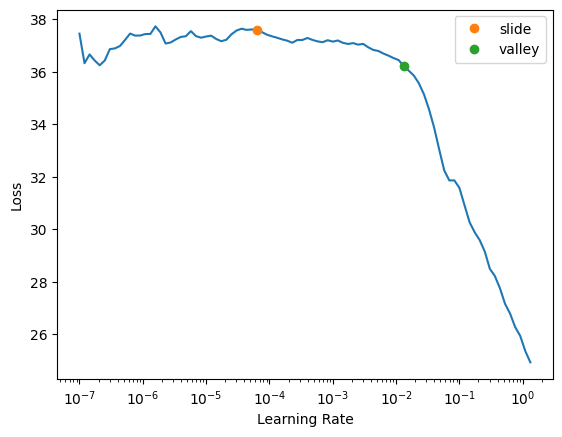

In [26]:
learn.lr_find(suggest_funcs=(slide, valley))

Oddly, it seems we can use a pretty high learning rate. Let's start with 1 and see how we go!

In [27]:
learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,mape,time
0,0.109989,0.065892,0.036501,00:34
1,0.060492,0.015672,0.020005,00:32
2,0.139747,0.059079,0.032907,00:32
3,0.079237,0.016051,0.018652,00:32
4,0.125006,0.068335,0.045534,00:33
5,0.178528,0.156081,0.066124,00:32
6,0.099443,0.027585,0.029980,00:32
7,0.090308,0.138824,0.056281,00:31
8,0.100645,0.064354,0.045009,00:32
9,0.108258,0.022425,0.022682,00:32


In [28]:
test_df = pd.read_csv('test.csv')
add_datepart(test_df, 'date')
test_dl = learn.dls.test_dl(test_df)

preds = learn.get_preds(dl=test_dl)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [29]:
preds = learn.get_preds(dl=test_dl)
preds[0]

tensor([[5.2219],
        [6.8456],
        [6.6413],
        ...,
        [7.5923],
        [7.0491],
        [7.1283]])

We mustn't forget that the model is outputting the outputs as a log, as we took the log of the input of `num_sold`. Before submitting our predictions, we must take the exponent of our outputs.

In [36]:
test_df['num_sold'] = preds[0].numpy()
test_df['num_sold'] = np.expm1(test_df['num_sold'])

In [37]:
test_df['num_sold']

,num_sold
0,184.279968
1,938.723206
2,765.093689
3,418.853577
4,550.304504
...,...
98545,455.292969
98546,2378.997314
98547,1981.775146
98548,1150.807251


In [38]:
sub_df = test_df[['id','num_sold']]
sub_df.to_csv('submission.csv', index=False)